In [ ]:
import pandas as pd
import os
import numpy as np
import re
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pdb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
org_path='/content/drive/MyDrive/Eye-tracking study/Data/Gaze data/v2/'
tsv_files=os.listdir(org_path)
import_path="/content/drive/MyDrive/Eye-tracking study/Experimental Setup/Sequences/Import.tsv"
sequence_path="/content/drive/MyDrive/Eye-tracking study/Experimental Setup/Sequences/Sequences - Combined.csv"
import_df = pd.read_csv(import_path,delimiter="\t",low_memory=False)
sequence_df = pd.read_csv(sequence_path,low_memory=False)



In [ ]:
def get_text_in_order(df):
  texts_gaze=[]
  i=0
  for media_name in set(list(df.MediaName)):
    try:

      if media_name[0]=='T':

        first_gaze=df[df["MediaName"]==media_name]["GazePointIndex"].iloc[1]
        texts_gaze.append((media_name,int(first_gaze)))

    except:
      print("ERRROR WITH: "+str(media_name))
  return sorted(texts_gaze, key=lambda x:x[1])


In [ ]:
#data = pd.read_csv(org_path+tsv_files[0],delimiter="\t",low_memory=False)
#texts=get_text_in_order(data)

In [ ]:
def arousalApply(mediaName,texts,arousal_level,arousal_org):
    if mediaName in texts:
        return arousal_level
    else:
        return arousal_org
def add_arousal_column(df,texts,arousal_sequence):
  texts=[text[0] for text in texts]
  print(texts)
  print(arousal_sequence)
  df["arousal"]=np.nan
  df["arousal"] = df.apply(lambda x: arousalApply(x['MediaName'], texts[0:8], arousal_sequence[0],x['arousal']), axis=1)
  df["arousal"] = df.apply(lambda x: arousalApply(x['MediaName'], texts[8:16], arousal_sequence[1],x['arousal']), axis=1)
  df["arousal"] = df.apply(lambda x: arousalApply(x['MediaName'], texts[16:24], arousal_sequence[2],x['arousal']), axis=1)
  return df

In [ ]:
#data=add_arousal_column(data,texts,"LHM")

In [ ]:
#names=[text[0] for text in texts]
#data[data['MediaName'].isin(names[:7])].head()

In [ ]:
def makeAOIColumn(df):
  df["aoi"]=np.nan
  for col in df.columns:
    match=re.match(".*Rectangle \d+",col)
    if match:
      aoiname=col.split(".")[0]
      df.loc[df[col] == 1, 'aoi'] = aoiname
  return df


In [ ]:
#data=makeAOIColumn(data)
#data=data.dropna(subset = ["aoi"], inplace=False)
#data[data['MediaName'].isin(names[:7])].head()

In [ ]:
def processMeanFixiationDuration(df):
  #First drop duplicates
  df=df.dropna(subset = ["aoi"], inplace=False)
  #Lets get only Fixiation gaze event types
  df=df[df["GazeEventType"]=="Fixation"][["arousal","aoi",\
                                                "GazeEventDuration","GazeEventType"\
                                                ,"ParticipantName","FixationIndex",\
                                                "MediaName"]].drop_duplicates(subset=["FixationIndex"])
  #Scale gaze event duration to 0 mean, min = 0, and max = 1
  df["ZeroMeanGazeDuration"]=df["GazeEventDuration"]-df["GazeEventDuration"].mean()
  min_max_scaler = preprocessing.RobustScaler()
  x_scaled = min_max_scaler.fit_transform(np.array([df["ZeroMeanGazeDuration"].to_list()]).reshape([-1,1]))
  df["NormalizedGazeDuration"]=x_scaled
  #Get the mean value of the normalized fixiation event per AOI
  temporal_df=df.groupby(["aoi","MediaName"],as_index=False)["NormalizedGazeDuration"].mean()
  merged_inner = pd.merge(left=temporal_df, right=df, left_on=["aoi","MediaName"], right_on=["aoi","MediaName"])
  #End of analisis of one user
  return merged_inner


In [ ]:
def processMeanFixiationDuration(df):
  #First drop duplicates
  df=df.dropna(subset = ["aoi"], inplace=False)
  #Lets get only Fixiation gaze event types
  df=df[df["GazeEventType"]=="Fixation"][["arousal","aoi",\
                                                "GazeEventDuration","GazeEventType"\
                                                ,"ParticipantName","FixationIndex",\
                                                "MediaName"]].drop_duplicates(subset=["FixationIndex"])
  df=df[df["GazeEventDuration"]<350]
  #Scale gaze event duration to 0 mean, min = 0, and max = 1
  df["ZeroMeanGazeDuration"]=df["GazeEventDuration"]-df["GazeEventDuration"].mean()
  min_max_scaler = preprocessing.MinMaxScaler()
  #pdb.set_trace()

  x_scaled = min_max_scaler.fit_transform(np.array([df["ZeroMeanGazeDuration"].to_list()]).reshape([-1,1]))
  df["NormalizedGazeDuration"]=x_scaled
  #Get the mean value of the normalized fixiation event per AOI

  temporal_df=df.groupby(["aoi","MediaName"],as_index=False)["NormalizedGazeDuration"].mean()
  merged_inner = pd.merge(left=temporal_df, right=df, left_on=["aoi","MediaName"], right_on=["aoi","MediaName"])
  countdf=merged_inner.groupby(['aoi','MediaName']).aoi.agg('count').to_frame('count').reset_index()
  merged_inner = pd.merge(left=countdf, right=merged_inner, left_on=["aoi","MediaName"], right_on=["aoi","MediaName"])
  #merged_inner["ZeroMeanCount"]=merged_inner["count"]-merged_inner["count"].mean()

  return merged_inner

In [ ]:
def processSingleParticipant(df):
  texts = get_text_in_order(df)
  ParticipantName = df["ParticipantName"].iloc[0]
  arousal_sequence=sequence_df[sequence_df["Participant"]==ParticipantName]["Audio sequence"].iloc[0]
  df = add_arousal_column(df,texts,arousal_sequence)
  df = makeAOIColumn(df)
  df = processMeanFixiationDuration(df)
  return df

In [ ]:
participant_dfs=[]
for participant in tsv_files:
  data = pd.read_csv(org_path+participant,delimiter="\t",low_memory=False)
  data = processSingleParticipant(data)
  participant_dfs.append(data)

ERRROR WITH: nan
['Text-1.png', 'Text-14.png', 'Text-19.png', 'Text-11.png', 'Text-22.png', 'Text-25.png', 'Text-10.png', 'Text-6.png', 'Text-21.png', 'Text-24.png', 'Text-16.png', 'Text-23.png', 'Text-7.png', 'Text-4.png', 'Text-13.png', 'Text-26.png', 'Text-3.png', 'Text-27.png', 'Text-18.png', 'Text-12.png', 'Text-9.png', 'Text-30.png', 'Text-8.png', 'Text-5.png']
LHM
ERRROR WITH: nan
['Text-3.png', 'Text-19.png', 'Text-12.png', 'Text-18.png', 'Text-9.png', 'Text-7.png', 'Text-20.png', 'Text-11.png', 'Text-4.png', 'Text-6.png', 'Text-14.png', 'Text-13.png', 'Text-21.png', 'Text-10.png', 'Text-24.png', 'Text-16.png', 'Text-17.png', 'Text-23.png', 'Text-1.png', 'Text-15.png', 'Text-8.png', 'Text-5.png', 'Text-2.png', 'Text-22.png']
LMH
ERRROR WITH: nan
['Text-18.png', 'Text-7.png', 'Text-5.png', 'Text-1.png', 'Text-16.png', 'Text-19.png', 'Text-17.png', 'Text-20.png', 'Text-21.png', 'Text-13.png', 'Text-4.png', 'Text-10.png', 'Text-14.png', 'Text-11.png', 'Text-9.png', 'Text-23.png', 

In [ ]:
concatenated_dataframes = pd.concat(participant_dfs, axis=0)

In [ ]:
data_analysis_df=concatenated_dataframes[["aoi","MediaName","ZeroMeanGazeDuration","arousal","ParticipantName","count"]]
data_analysis_df.drop_duplicates()

,aoi,MediaName,ZeroMeanGazeDuration,arousal,ParticipantName,count
0,AOI[Rectangle 10]Hit,Text-11.png,26.949721,L,P01,7
1,AOI[Rectangle 10]Hit,Text-11.png,-56.050279,L,P01,7
3,AOI[Rectangle 10]Hit,Text-11.png,43.949721,L,P01,7
4,AOI[Rectangle 10]Hit,Text-11.png,-65.050279,L,P01,7
5,AOI[Rectangle 10]Hit,Text-11.png,-98.050279,L,P01,7
...,...,...,...,...,...,...
3081,AOI[Rectangle 9]Hit,Text-9.png,-14.061244,H,P16,14
3082,AOI[Rectangle 9]Hit,Text-9.png,60.938756,H,P16,14
3083,AOI[Rectangle 9]Hit,Text-9.png,1.938756,H,P16,14
3084,AOI[Rectangle 9]Hit,Text-9.png,-106.061244,H,P16,14


In [ ]:
concatenated_dataframes.head()

,aoi,MediaName,count,NormalizedGazeDuration_x,arousal,GazeEventDuration,GazeEventType,ParticipantName,FixationIndex,ZeroMeanGazeDuration,NormalizedGazeDuration_y
0,AOI[Rectangle 10]Hit,Text-11.png,7,0.225235,L,200,Fixation,P01,629.0,26.949721,0.485401
1,AOI[Rectangle 10]Hit,Text-11.png,7,0.225235,L,117,Fixation,P01,630.0,-56.050279,0.182482
2,AOI[Rectangle 10]Hit,Text-11.png,7,0.225235,L,117,Fixation,P01,631.0,-56.050279,0.182482
3,AOI[Rectangle 10]Hit,Text-11.png,7,0.225235,L,217,Fixation,P01,632.0,43.949721,0.547445
4,AOI[Rectangle 10]Hit,Text-11.png,7,0.225235,L,108,Fixation,P01,633.0,-65.050279,0.149635


### Analisis of Fixiation lenght




Analisys of variance

In [ ]:
data_analysis_fixiation_lenght_df=concatenated_dataframes[["aoi","MediaName","NormalizedGazeDuration_x","arousal"]]
data_analysis_fixiation_lenght_df=data_analysis_fixiation_lenght_df.drop_duplicates()
mod = ols("NormalizedGazeDuration_x~arousal",data=data_analysis_fixiation_lenght_df).fit()
aov = sm.stats.anova_lm(mod, type=2)

In [ ]:
aov

,df,sum_sq,mean_sq,F,PR(>F)
arousal,2.0,0.053219,0.026609,2.073859,0.125891
Residual,2822.0,36.208730,0.012831,NaN,NaN


Box plot

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


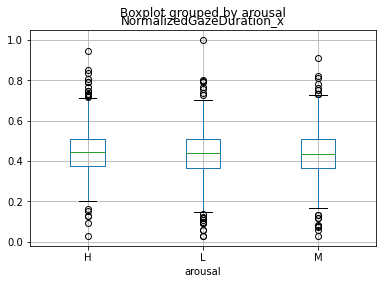

In [ ]:
data_analysis_fixiation_lenght_df.boxplot("NormalizedGazeDuration_x", by="arousal")

In [ ]:
data_analysis_fixiation_lenght_df.groupby("arousal").mean()

,NormalizedGazeDuration_x
arousal,
H,0.446966
L,0.437504
M,0.438013


In [ ]:
for i,participant in enumerate(participant_dfs):
  participant_fixiation_lenght_df=participant[["aoi","MediaName","NormalizedGazeDuration_x","arousal"]]
  participant_fixiation_lenght_df=participant_fixiation_lenght_df.drop_duplicates()
  participant_fixiation_lenght_df.groupby("arousal").mean()
  print("PARTICIPANT: "+str(i+1))
  print(participant_fixiation_lenght_df.groupby("arousal").mean())

PARTICIPANT: 1
         NormalizedGazeDuration_x
arousal                          
H                        0.363566
L                        0.386032
M                        0.404836
PARTICIPANT: 2
         NormalizedGazeDuration_x
arousal                          
H                        0.382299
L                        0.385565
M                        0.372416
PARTICIPANT: 3
         NormalizedGazeDuration_x
arousal                          
H                        0.430280
L                        0.402954
M                        0.372372
PARTICIPANT: 4
         NormalizedGazeDuration_x
arousal                          
H                        0.385455
L                        0.348164
M                        0.392477
PARTICIPANT: 5
         NormalizedGazeDuration_x
arousal                          
H                        0.561734
L                        0.520179
M                        0.536712
PARTICIPANT: 6
         NormalizedGazeDuration_x
arousal                   

PARTICIPANT: 1
PARTICIPANT: 2
PARTICIPANT: 3
PARTICIPANT: 4
PARTICIPANT: 5


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

PARTICIPANT: 6
PARTICIPANT: 7
PARTICIPANT: 8
PARTICIPANT: 9
PARTICIPANT: 10


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

PARTICIPANT: 11
PARTICIPANT: 12
PARTICIPANT: 13


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

PARTICIPANT: 14
PARTICIPANT: 15
PARTICIPANT: 16


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

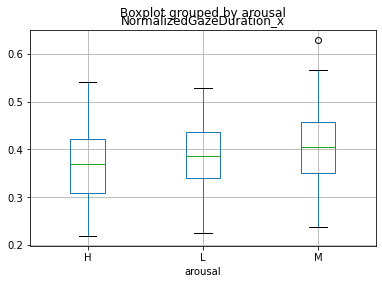

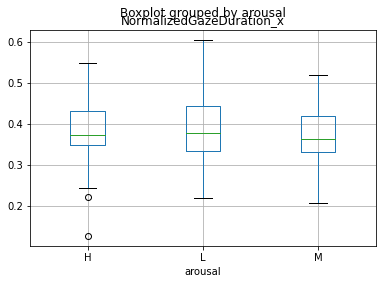

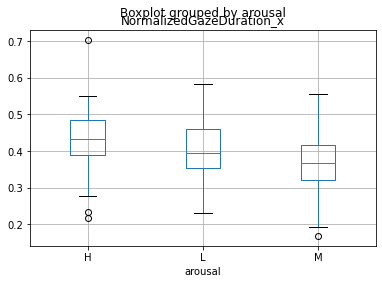

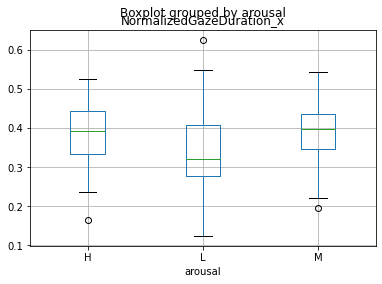

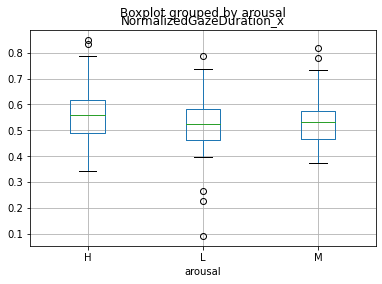

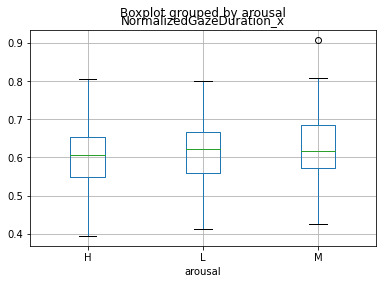

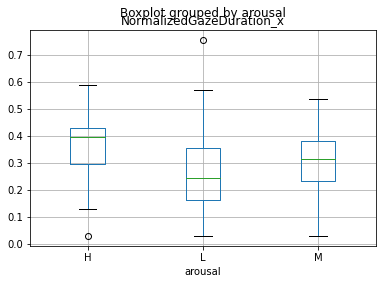

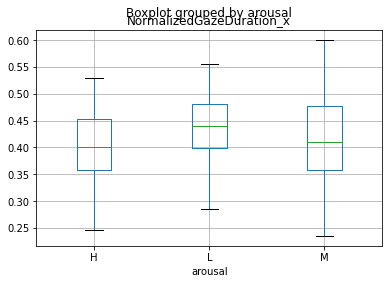

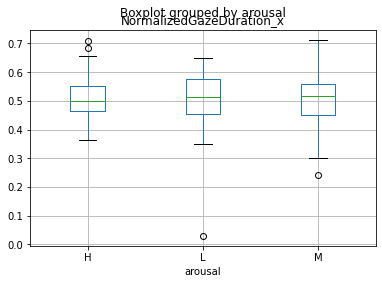

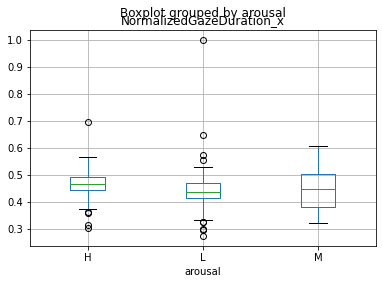

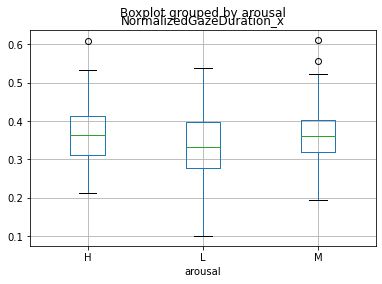

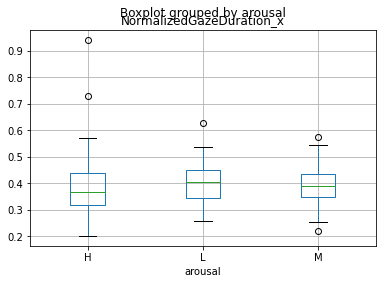

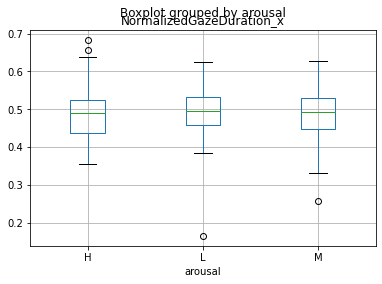

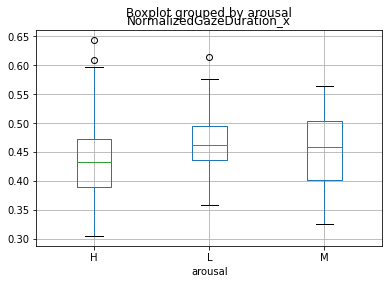

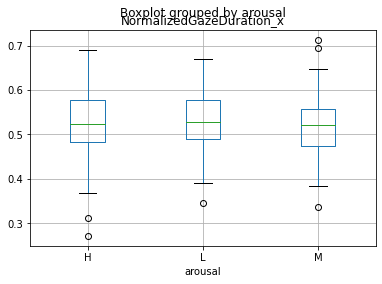

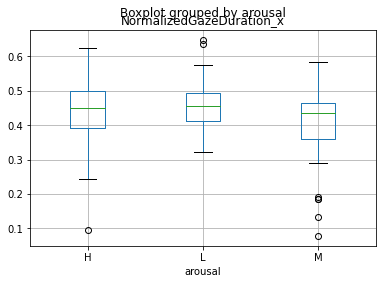

In [ ]:
for i,participant in enumerate(participant_dfs):
  participant_fixiation_lenght_df=participant[["aoi","MediaName","NormalizedGazeDuration_x","arousal"]]
  participant_fixiation_lenght_df=participant_fixiation_lenght_df.drop_duplicates()
  participant_fixiation_lenght_df.groupby("arousal").mean()
  print("PARTICIPANT: "+str(i+1))
  participant_fixiation_lenght_df.boxplot("NormalizedGazeDuration_x", by="arousal")


## Fixiation Count analysis

In [ ]:
data_analysis_fixiation_count_df=concatenated_dataframes[["aoi","MediaName","count","arousal"]]
data_analysis_fixiation_count_df=data_analysis_fixiation_count_df.drop_duplicates()
mod = ols("count~arousal",data=data_analysis_fixiation_count_df).fit()
aov = sm.stats.anova_lm(mod, type=2)

In [ ]:
aov

,df,sum_sq,mean_sq,F,PR(>F)
arousal,2.0,118.146000,59.07300,0.960353,0.382896
Residual,2542.0,156362.818243,61.51173,NaN,NaN


In [ ]:
data_analysis_fixiation_count_df.groupby("arousal").mean()

,count
arousal,
H,14.063905
L,13.813760
M,14.340723


In [ ]:
for i,participant in enumerate(participant_dfs):
  participant_fixiation_lenght_df=participant[["aoi","MediaName","count","arousal"]]
  participant_fixiation_lenght_df=participant_fixiation_lenght_df.drop_duplicates()
  participant_fixiation_lenght_df.groupby("arousal").mean()
  print("PARTICIPANT: "+str(i+1))
  print(participant_fixiation_lenght_df.groupby("arousal").mean())

PARTICIPANT: 1
             count
arousal           
H        12.419355
L        12.092308
M        13.526316
PARTICIPANT: 2
             count
arousal           
H        10.779661
L        13.666667
M        11.440678
PARTICIPANT: 3
             count
arousal           
H        14.310345
L        12.850000
M        14.000000
PARTICIPANT: 4
             count
arousal           
H        20.327586
L        14.293103
M        24.421875
PARTICIPANT: 5
             count
arousal           
H         9.300000
L        10.681818
M         9.666667
PARTICIPANT: 6
            count
arousal          
H        8.350877
L        8.872727
M        9.300000
PARTICIPANT: 7
             count
arousal           
H        14.555556
L         8.239130
M        13.651163
PARTICIPANT: 8
             count
arousal           
H        10.603448
L        11.620690
M        11.400000
PARTICIPANT: 9
             count
arousal           
H        10.762712
L        12.786885
M        11.672131
PARTICIPANT: 10

PARTICIPANT: 1
PARTICIPANT: 2
PARTICIPANT: 3
PARTICIPANT: 4
PARTICIPANT: 5


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

PARTICIPANT: 6
PARTICIPANT: 7
PARTICIPANT: 8
PARTICIPANT: 9
PARTICIPANT: 10


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

PARTICIPANT: 11
PARTICIPANT: 12
PARTICIPANT: 13
PARTICIPANT: 14
PARTICIPANT: 15


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

PARTICIPANT: 16


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


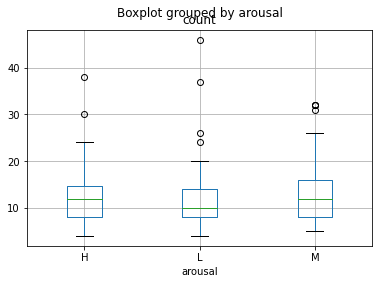

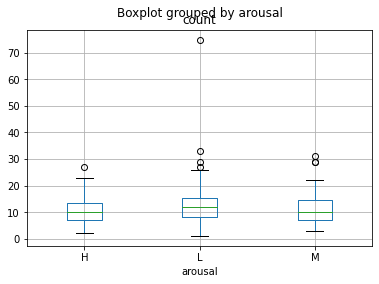

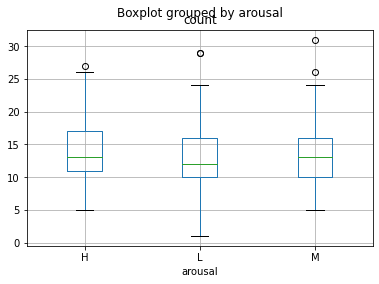

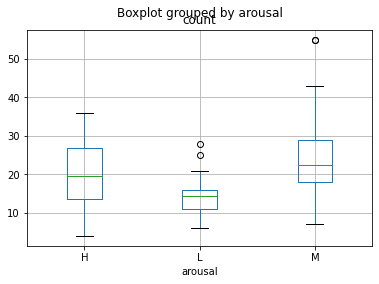

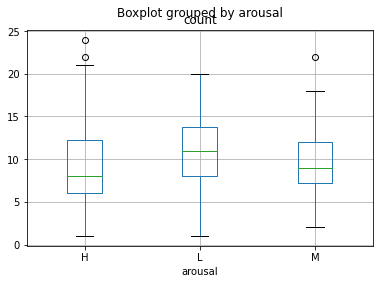

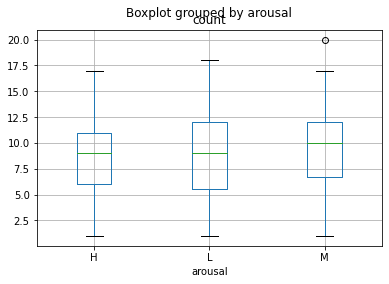

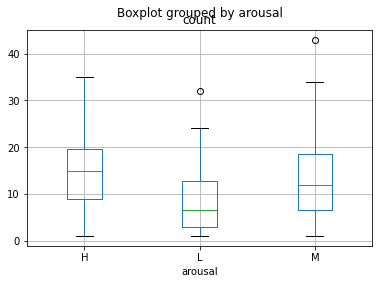

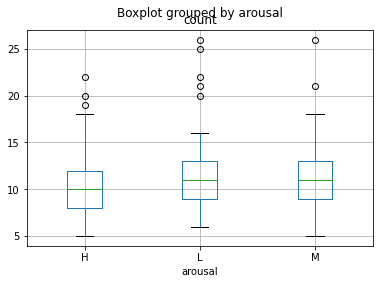

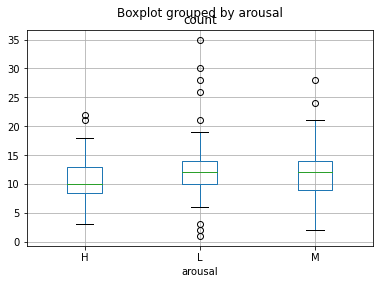

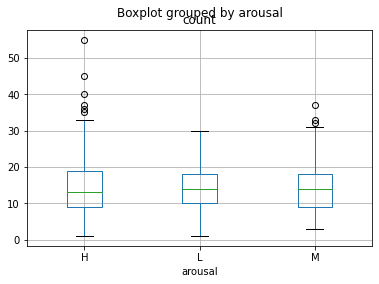

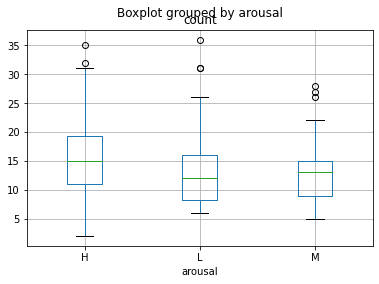

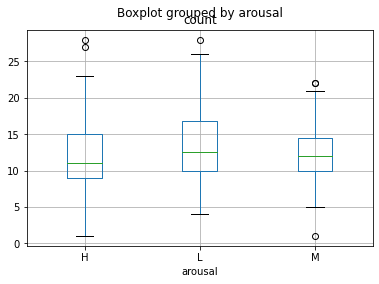

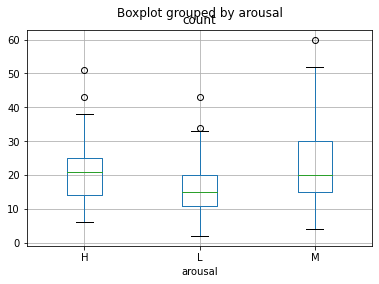

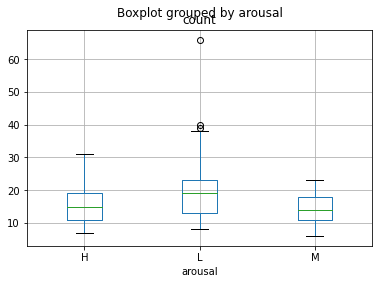

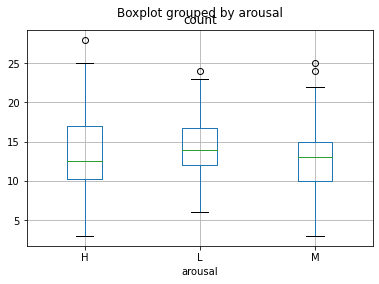

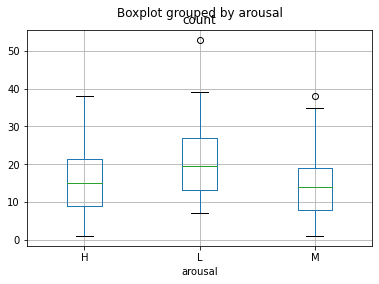

In [ ]:
for i,participant in enumerate(participant_dfs):
  participant_fixiation_lenght_df=participant[["aoi","MediaName","count","arousal"]]
  participant_fixiation_lenght_df=participant_fixiation_lenght_df.drop_duplicates()
  participant_fixiation_lenght_df.groupby("arousal").mean()
  print("PARTICIPANT: "+str(i+1))
  participant_fixiation_lenght_df.boxplot("count", by="arousal")

## Selective analysis based on participant accuracy

Now we only analyse the data for participants who had an score above 85%

In [ ]:
choseen_participants_ids=[0,3,9,10,11,15]
choosen_participants_df=[participant_dfs[id] for id in choseen_participants_ids]
concatenated_dataframes_selected = pd.concat(choosen_participants_df, axis=0)
data_analysis_fixiation_count_df=concatenated_dataframes_selected[["aoi","MediaName","count","arousal"]]
data_analysis_fixiation_count_df=data_analysis_fixiation_count_df.drop_duplicates()
mod = ols("count~arousal",data=data_analysis_fixiation_count_df).fit()
aov = sm.stats.anova_lm(mod, type=2)

In [ ]:
aov

,df,sum_sq,mean_sq,F,PR(>F)
arousal,2.0,183.321831,91.660916,1.389116,0.249753
Residual,1050.0,69284.343886,65.985089,NaN,NaN


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


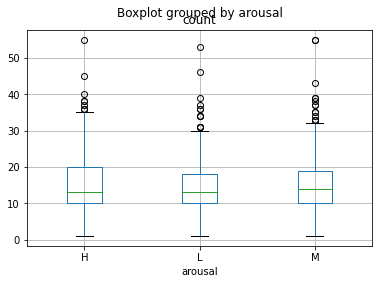

In [ ]:
data_analysis_fixiation_count_df.boxplot("count", by="arousal")

## Probability of Rereading


In [ ]:
participant_dfs[0].sort_values(by=['FixationIndex'])

,aoi,MediaName,count,NormalizedGazeDuration_x,arousal,GazeEventDuration,GazeEventType,ParticipantName,FixationIndex,ZeroMeanGazeDuration,NormalizedGazeDuration_y
153,AOI[Rectangle 2]Hit,Text-1.png,15,0.410219,L,150,Fixation,P01,163.0,-23.050279,0.302920
154,AOI[Rectangle 2]Hit,Text-1.png,15,0.410219,L,183,Fixation,P01,166.0,9.949721,0.423358
155,AOI[Rectangle 2]Hit,Text-1.png,15,0.410219,L,175,Fixation,P01,167.0,1.949721,0.394161
156,AOI[Rectangle 2]Hit,Text-1.png,15,0.410219,L,233,Fixation,P01,168.0,59.949721,0.605839
157,AOI[Rectangle 2]Hit,Text-1.png,15,0.410219,L,167,Fixation,P01,169.0,-6.050279,0.364964
...,...,...,...,...,...,...,...,...,...,...,...
1771,AOI[Rectangle 6]Hit,Text-5.png,14,0.402503,M,183,Fixation,P01,3591.0,9.949721,0.423358
1772,AOI[Rectangle 6]Hit,Text-5.png,14,0.402503,M,233,Fixation,P01,3592.0,59.949721,0.605839
1773,AOI[Rectangle 6]Hit,Text-5.png,14,0.402503,M,242,Fixation,P01,3593.0,68.949721,0.638686
942,AOI[Rectangle 3]Hit,Text-5.png,14,0.432742,M,67,Fixation,P01,3594.0,-106.050279,0.000000


In [ ]:
def makeRereadColumn(df):
  df=df.sort_values(by=['FixationIndex'])
  visited=[]
  revisited=[]
  reread_column=[]
  prev_aoi=''
  for index,row in df.iterrows():
    media=row["MediaName"]
    aoi=row["aoi"]
    if media+aoi in visited:
      if media+aoi in revisited:
        reread_column.append(1)
      else:
        if media+aoi==prev_aoi:
          reread_column.append(0)
        else:
          prev_aoi_index=int(re.findall(r'\d+', prev_aoi)[0])
          curr_aoi_index=int(re.findall(r'\d+', aoi)[0])
          if abs(prev_aoi_index-curr_aoi_index)>1:
            reread_column.append(1)
            revisited.append(media+aoi)
          else:
            reread_column.append(0)
    else:
      reread_column.append(0)
      visited.append(media+aoi)
    prev_aoi=media+aoi
  df["revisited"]=reread_column
  return df




In [ ]:
testdf=participant_dfs[0][["aoi","MediaName","count","arousal","FixationIndex"]].drop_duplicates()

In [ ]:
ans=makeRereadColumn(testdf)

In [ ]:
participants_rereaded=[]
for participantdf in participant_dfs:
  testdf=participantdf[["aoi","MediaName","count","arousal","FixationIndex"]].drop_duplicates()
  ans=makeRereadColumn(testdf)
  left=ans.groupby(["aoi","MediaName"],as_index=False)["revisited"].sum()
  right=participantdf[["aoi","MediaName","count","arousal"]]
  merged_inner=pd.merge(left=left, right=right, left_on=["aoi","MediaName"], right_on=["aoi","MediaName"]).drop_duplicates()
  participants_rereaded.append(merged_inner)

In [ ]:
concatenated_rereaded = pd.concat(participants_rereaded, axis=0)

In [ ]:
concatenated_rereaded["rereadprob"]=concatenated_rereaded["revisited"]/concatenated_rereaded["count"]

In [ ]:
concatenated_rereaded.head()

,aoi,MediaName,revisited,count,arousal,rereadprob
0,AOI[Rectangle 10]Hit,Text-11.png,0,7,L,0.000000
7,AOI[Rectangle 10]Hit,Text-14.png,5,6,L,0.833333
13,AOI[Rectangle 10]Hit,Text-16.png,3,4,H,0.750000
17,AOI[Rectangle 10]Hit,Text-18.png,1,7,M,0.142857
24,AOI[Rectangle 10]Hit,Text-19.png,0,8,L,0.000000


In [ ]:
mod = ols("rereadprob~arousal",data=concatenated_rereaded).fit()
aov = sm.stats.anova_lm(mod, type=2)
aov

,df,sum_sq,mean_sq,F,PR(>F)
arousal,2.0,1.140402,0.570201,3.979679,0.018797
Residual,2823.0,404.474315,0.143278,NaN,NaN


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


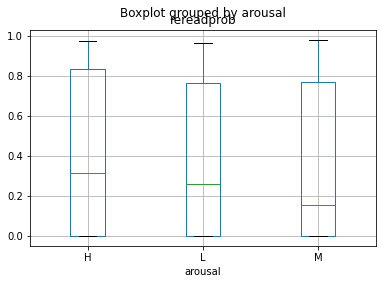

In [ ]:
concatenated_rereaded.boxplot("rereadprob", by="arousal")

In [ ]:
choseen_participants_ids=[0,3,9,10,11,15]
choosen_participants_df=[participants_rereaded[id] for id in choseen_participants_ids]
concatenated_rereaded = pd.concat(choosen_participants_df, axis=0)
concatenated_rereaded["rereadprob"]=concatenated_rereaded["revisited"]/concatenated_rereaded["count"]

In [ ]:
mod = ols("rereadprob~arousal",data=concatenated_rereaded).fit()
aov = sm.stats.anova_lm(mod, type=2)
aov

,df,sum_sq,mean_sq,F,PR(>F)
arousal,2.0,1.008765,0.504382,3.620773,0.027085
Residual,1089.0,151.700315,0.139302,NaN,NaN


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


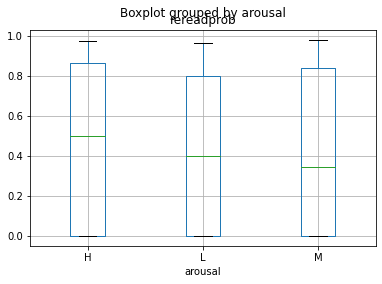

In [ ]:
concatenated_rereaded.boxplot("rereadprob", by="arousal")

In [ ]:
import scipy.stats as stats

In [ ]:
stats.ttest_ind(concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'H'], concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'L'])

Ttest_indResult(statistic=2.038374880679349, pvalue=0.041870379314912894)

In [ ]:
stats.ttest_ind(concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'H'], concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'M'])

Ttest_indResult(statistic=2.5110124239265477, pvalue=0.01225499843935643)

In [ ]:
stats.ttest_ind(concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'M'], concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'L'])

Ttest_indResult(statistic=-0.5284797614897355, pvalue=0.5973294721844784)

In [ ]:
concatenated_rereaded = pd.concat(participants_rereaded, axis=0)
concatenated_rereaded["rereadprob"]=concatenated_rereaded["revisited"]/concatenated_rereaded["count"]

In [ ]:
stats.ttest_ind(concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'H'], concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'L'])

Ttest_indResult(statistic=1.4112533829965002, pvalue=0.15833511484177792)

In [ ]:
stats.ttest_ind(concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'H'], concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'M'])

Ttest_indResult(statistic=2.793346616943517, pvalue=0.005269552946069286)

In [ ]:
stats.ttest_ind(concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'L'], concatenated_rereaded['rereadprob'][concatenated_rereaded['arousal'] == 'M'])

Ttest_indResult(statistic=1.4309887467711944, pvalue=0.15259902077721346)